**<h1><center>Image Inpainting with CNN</center></h1>**

## **CIFAR-100 Inpainting**

### **Description**

In this assignment, you are asked to design and train a convolutional neural network model for the image inpainting task. In short, inpainting is a process of filling in the missing parts of an image. You will be applying this task on the preprocessed CIFAR-100 dataset, which is created for this homework by processing the original [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html?ref=assemblyai.com) images. It contains RGB real-life images with the size of 28x28 pixel resolution. You can see a subset of the dataset below. The download link of the dataset is provided in the following parts.

![CIFAR-100 Samples](https://drive.google.com/uc?export=view&id=1drp11GJ3QnRivkYLR0nh9RVOi9lnIh8o)

**Using PyTorch is mandatory** for this assignment. You are requested to **submit only a single *.ipynb file** in your submissions (no report needed). If you want to provide further explanations about your work, you can add Markdown cells for this purpose. From [this link](https://www.markdownguide.org/), you can get familiar with the Markdown syntax if you need. Upload your homework with the following filename convention: **\<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb**

Note that this assignment needs a CUDA-enabled GPU to be able to train the models in a reasonable time. If you do not have one, it is suggested to use the [Colab](https://colab.research.google.com/) environment.

**Contact:** [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

### **Importing the Libraries**

In the cell below,  some utilities that you can make use of in this assignment are imported. You can edit these imports considering your implementation as long as you use PyTorch.

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os

### **Environment Check**

In the cell below, you can test whether hardware acceleration with GPU is enabled in your machine or not. If it is enabled, the printed device should be 'cuda'.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Current device:', device)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Current device: cuda
GPU Name: Tesla T4
Total GPU Memory: 14.7 GB


### **Setting Library Seeds for Reproducibility**

**DO NOT CHANGE**<br>
To make a fair evaluation, the seed values are set for random sampling methods in PyTorch, NumPy, and Python random library. Please do not change these values.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
seed_everything(464)

### **Preparing the Dataset**

The CIFAR-100 dataset is downloadable from [this link](https://drive.google.com/file/d/1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL/view?usp=share_link). If you are using Colab or a Linux machine, you can uncomment and run the below cell to download and extract the dataset automatically.

In [ ]:
import gdown # Library to download files from Google Drive
!gdown 1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL # Google Drive ID of the zip file to be downloaded
!unzip -oq cifar100.zip # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

Downloading...
From: https://drive.google.com/uc?id=1KiymtjUjuEJjUTO_qB9ifpLC_UvJEhoL
To: /content/cifar100.zip
100% 64.1M/64.1M [00:01<00:00, 54.9MB/s]


### **Implementing a Custom Dataset [25 Points]**

In this part, you are requested to implement a custom PyTorch dataset class that reads CIFAR-100 images from a dataset split folder. There are two split folders called train and test in the dataset. The model class should take the root directory of a split in the \_\_init\_\_ function and read the images accordingly. Before returning the requested images, you should apply the following steps:

* Apply bicubic interpolation using PIL to resize the images from (28,28) to (32,32) resolution.
* Convert images to Tensor object
* Normalize tensor values to scale them in the range of (-1,1)

Note that reading images in the \_\_getitem\_\_ function makes the training process slow for this dataset because reading such small-sized images as a batch is slower than the forward pass process of a simple neural network. Therefore, it is suggested to read and store the images in an array in the \_\_init\_\_ function and return them in the \_\_getitem\_\_ function when they are requested by the DataLoader object.

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CifarDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []

        # Read and store images in an array during initialization
        for object_name in os.listdir(root_dir):
            object_path = os.path.join(root_dir, object_name)
            if os.path.isdir(object_path):
                for filename in os.listdir(object_path):
                    img_path = os.path.join(object_path, filename)
                    image = Image.open(img_path)
                    self.images.append(image)

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.images)

    def __getitem__(self, data_id):
        # Return the image at the given index
        img = self.images[data_id]

        if self.transform:
            img = self.transform(img)

        # Explicitly move the tensor to the desired device
        img = img.to(device)

        return img


Create a dataset and a data loader object for training and test splits. Set batch sizes to 64 and 512 for training and test data loaders, respectively. Enable shuffling in the training data loader and disable it in the test data loader.

In [ ]:
# Set the root directories for train and test splits
train_root_dir = "cifar100/train"
test_root_dir = "cifar100/test"

# Create transforms for resizing, converting to Tensor, and normalization
transform = transforms.Compose([
    transforms.Resize((32, 32), interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create dataset and dataloader objects for training and test splits
train_dataset = CifarDataset(root_dir=train_root_dir, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = CifarDataset(root_dir=test_root_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


**Do not change** the below code. If your implementation is correct, you should be seeing a grid of CIFAR-100 images properly.

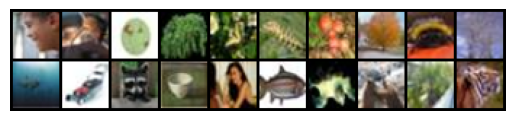

In [ ]:
## Uncomment the cell when the dataloader is ready

images = next(iter(train_dataloader)) # Taking one batch from the dataloader
images = (images + 1) / 2
grid_img = torchvision.utils.make_grid(images[:20], nrow=10)
plt.axis('off')
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### **Constructing Convolutional Autoencoder Network [35 Points]**

Autoencoder networks learn how to compress and reconstruct input data. It consists of two networks called the encoder and the decoder. The encoder network compresses the input data, and the decoder network regenerates the data from its compressed version. In this part, you are requested to implement an autoencoder model using convolutional layers. The architecture of the convolutional autoencoder is shown in the below figure.

![Convolutional Autoencoder Architecture](https://drive.google.com/uc?export=view&id=19RqHo2PatyoFl7om8OUxBRb1uYAVGmhF)

The (in_channel, out_channel) pairs of the layers should be defined as follows:

**Encoder:**
- (3, 16)
- (16, 32)
- (32, 64)

**Decoder:**
- (64, 32)
- (32, 16)
- (16, 3)

You are free to choose the kernel and padding sizes of the layers. In each layer, [2D batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) should be applied and the resulting values should be passed through a LeakyReLU layer with slope 0.2, which is the activation function. Since the image pixel value range is set to [-1,1] in the dataset, the outputs should be bounded so. Therefore, you should be using a Tanh activation function in the last layer instead of the normalization and LeakyReLU layers.

In the encoder part of the network, use max pooling in each layer for decreasing the resolution by half. The stride size should be set to one for the convolution layers. In the decoder network, use [transposed convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) (deconvolution) layers with stride two for increasing the resolution back.

In [ ]:
import torch.nn as nn

class CifarAutoencoder(nn.Module):
    def __init__(self):
        super(CifarAutoencoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### **Implementing the Training Loop [15 Points]**

Define your training loop in this function. In the following parts, this function will be called to train the convolutional autoencoder. The input arguments are provided below. Apply the training progress and return a list of losses that are calculated on each epoch. You should sum the iteration losses up during an epoch and take the mean of them to calculate the running loss of that epoch.

To be able to learn inpainting, you should mask the input images as follows:

![CIFAR Masking](https://drive.google.com/uc?export=view&id=1tlB0mNH4B5dKfokoe162qWgXgPDnOQi2)

Simply, you should set the input tensor columns starting from 16 to 32 as -1 (black pixel). For the loss function, you should use the original image as the ground truth image so that the network learns how to fill the masked area of the input image and output the restored image. Before assigning the black pixels, do not forget to clone the original image to use it later in the loss function.

In [ ]:
def train_model(model, train_dataloader, optimizer, loss_func, num_epochs):
    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch in train_dataloader:
            # Mask the input images
            input_images = batch.clone()
            input_images[:, :, :, 16:32] = -1  # Set the masked area to black

            # Forward pass
            outputs = model(input_images)

            # Calculate the loss
            loss = loss_func(outputs, batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate the mean loss for the epoch
        mean_epoch_loss = epoch_loss / len(train_dataloader)
        losses.append(mean_epoch_loss)

        # Print the loss for every epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {mean_epoch_loss}")

    return losses

### **Implementing the Evaluation Function [15 Points]**

Implement an evaluation function that returns the mean MSE calculated over the test dataset samples.

In [ ]:
import torch.nn.functional as F

def evaluate_model(model, test_dataloader):
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in test_dataloader:
            # Mask the input images
            input_images = batch.clone()
            input_images[:, :, :, 16:32] = -1  # Set the masked area to black

            # Forward pass
            outputs = model(input_images)

            # Calculate MSE
            mse = F.mse_loss(outputs, batch, reduction='sum')
            total_mse += mse.item()
            num_samples += batch.size(0)

    # Calculate the mean MSE over all test samples
    mean_mse = total_mse / num_samples
    return mean_mse


### **Inpainting Visualization Function**

The below code will be used to visualize the outputs of the trained models later. **Do not change the codes in the cell**.

In [ ]:
def visualize_inpainting(model, dataset):
    seed_everything(464)
    dataloader = DataLoader(dataset, batch_size=10, shuffle=True)
    images = next(iter(dataloader)) # Taking one batch from the dataloader
    images = images
    model.eval()
    with torch.no_grad():
      masked_images = images.clone()
      masked_images[:,:,:,16:] = -1
      inpainted_images = model(masked_images.cuda()).cpu()
    images = (images + 1) / 2
    masked_images = (masked_images + 1) / 2
    inpainted_images = (inpainted_images + 1) / 2
    images_concat = torch.cat((images, masked_images, inpainted_images), dim=2)
    grid_img = torchvision.utils.make_grid(images_concat, nrow=10)
    plt.axis('off')
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

### **Training and Evaluating the Model [10 Points]**

Define your loss function as MSE, set learning rate to 2e-4, create Adam optimizer, and set number of epochs to 50. Later, call the train_model function that you implemented. Visualize the returned losses on a plot (loss vs. epoch). Lastly, call evaluate_model function that you implemented and print the mean square error that your model reached on the test dataset. Also, call the visualize_inpainting function to observe the final inpainting results on the test dataset.



Epoch [1/50], Loss: 0.14746080862972744
Epoch [2/50], Loss: 0.1156385443971285
Epoch [3/50], Loss: 0.11161259499847737
Epoch [4/50], Loss: 0.10938143157555014
Epoch [5/50], Loss: 0.10822258589555846
Epoch [6/50], Loss: 0.10724522020010387
Epoch [7/50], Loss: 0.10645473542649422
Epoch [8/50], Loss: 0.10602213127914902
Epoch [9/50], Loss: 0.10567590031210723
Epoch [10/50], Loss: 0.10506189896551239
Epoch [11/50], Loss: 0.10476473978032237
Epoch [12/50], Loss: 0.10444565759519177
Epoch [13/50], Loss: 0.10417494588457715
Epoch [14/50], Loss: 0.10395041256761917
Epoch [15/50], Loss: 0.10380335253141725
Epoch [16/50], Loss: 0.10344395428286184
Epoch [17/50], Loss: 0.10328737825460141
Epoch [18/50], Loss: 0.10308015997261952
Epoch [19/50], Loss: 0.10292898745411802
Epoch [20/50], Loss: 0.10272758265437983
Epoch [21/50], Loss: 0.10255388797396589
Epoch [22/50], Loss: 0.10250289246554264
Epoch [23/50], Loss: 0.10225423404475308
Epoch [24/50], Loss: 0.10212900364757194
Epoch [25/50], Loss: 0.102

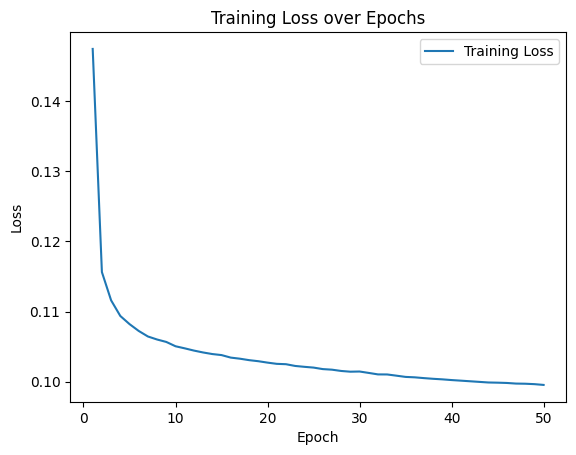

Mean Squared Error on Test Dataset: 312.72482421875


In [ ]:
seed_everything(464)

# Assuming CifarAutoencoder, train_model, evaluate_model, and visualize_inpainting are defined

# Instantiate the model
model = CifarAutoencoder()

# Define the loss function (MSE), learning rate, and create an Adam optimizer
loss_func = nn.MSELoss()
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Set the number of epochs
num_epochs = 50

# Train the model
losses = train_model(model, train_dataloader, optimizer, loss_func, num_epochs)

# Visualize the training losses
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Evaluate the model on the test dataset
test_mse = evaluate_model(model, test_dataloader)
print(f"Mean Squared Error on Test Dataset: {test_mse}")

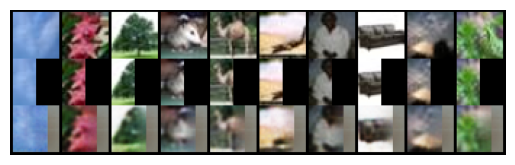

In [ ]:
visualize_inpainting(model, test_dataset)